# Topological Impurity

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from molecularnetwork import MolecularNetwork
from sklearn.base import BaseEstimator, ClassifierMixin
from loguru import logger
from tqdm import tqdm, trange

In [9]:
df = pd.read_csv('../data/simpd/CHEMBL3887063.csv')

In [10]:
df

,Unnamed: 0,compound_chembl_id,canonical_smiles,standard_value,standard_units,standard_relation,standard_type,pchembl_value,pActivity,active,split
0,438,CHEMBL3694196,Cc1ccc(C(=O)Nc2ccc(N(C)CCN(C)C)c(C(F)(F)F)c2)c...,2.0,nM,=,IC50,8.70,8.698970,1,train
1,295,CHEMBL3694039,CN1CCN(c2nc(N)c3ncnc(Nc4ccc(F)c(C(=O)Nc5cc(C(C...,676.0,nM,=,IC50,6.17,6.170053,0,train
2,439,CHEMBL3694197,Cc1ccc(C(=O)Nc2ccc(N(C)CCN(C)C)c(C(F)(F)F)c2)c...,4.0,nM,=,IC50,8.40,8.397940,0,test
3,33,CHEMBL3641054,COCCN1CCN(c2ncc3ncnc(Nc4cc(C(=O)Nc5ccc(OC)c(C(...,2.0,nM,=,IC50,8.70,8.698970,1,train
4,428,CHEMBL3694182,Cc1ccc(C(=O)Nc2ccc(N(C)CCN(C)C)c(C(F)(F)F)c2)c...,3.0,nM,=,IC50,8.52,8.522879,0,train
...,...,...,...,...,...,...,...,...,...,...,...
638,138,CHEMBL3641169,COc1ccc(NC(=O)c2ccc(C)c(Nc3ncnc4cnc(N5CCN(CC6C...,3.0,nM,=,IC50,8.52,8.522879,0,train
639,496,CHEMBL3697769,Cc1ccc(C(=O)Nc2cccc(N(C)C)c2)cc1Nc1ncnc2cnc(N3...,15.0,nM,=,IC50,7.82,7.823909,0,train
640,537,CHEMBL3697814,COc1ccc(C(F)(F)F)cc1NC(=O)c1ccc(C)c(Nc2ncnc3cn...,120.0,nM,=,IC50,6.92,6.920819,0,train
641,355,CHEMBL3694101,COc1ccc(NC(=O)c2ccc(F)c(Nc3ncnc4cnc(N5CCCC5)nc...,5.0,nM,=,IC50,8.30,8.301030,0,train


In [11]:
# Train DF
train_df = df[df["split"] == "test"]

# Define SMILES strings and classes
smiles_list = train_df["canonical_smiles"].values
classes = train_df["active"].values

# Create MolecularNetwork instance
network = MolecularNetwork(descriptor="morgan2", sim_metric="tanimoto", sim_threshold=0.6)

# Generate the molecular network graph
graph = network.create_graph(smiles_list, classes)

In [12]:
def draw_graph_with_attributes(G, node_attribute='categorical_label', edge_attribute='similarity'):
    """
    Draws a molecular network graph with node colors based on categorical labels and edge widths based on edge weights.

    Args:
      G: NetworkX graph representing the molecular network.
      node_attribute: Name of the node attribute containing categorical labels (default: 'categorical_label').
      edge_attribute: Name of the edge attribute containing weights (default: 'similarity').
    """

    # Extract unique categorical labels
    unique_labels = set(nx.get_node_attributes(G, node_attribute).values())
    num_labels = len(unique_labels)

    # Define a colormap
    colormap = plt.cm.get_cmap('nipy_spectral', num_labels)

    # Create a dictionary mapping labels to colors and a list of label names for legend
    color_map = {label: colormap(i) for i, label in enumerate(unique_labels)}
    label_names = list(color_map.keys())

    # Extract node colors based on categorical labels
    node_colors = [color_map[G.nodes[n][node_attribute]] for n in G.nodes]

    # Extract edge widths based on edge weights
    edge_widths = [G[u][v][edge_attribute] for u, v in G.edges]

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.2)  # you can choose different layout algorithms

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20, label=False)

    # Draw edges with widths corresponding to their weights
    for (u, v), width in zip(G.edges, edge_widths):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, edge_color='red', label=False)

    # Create legend entries with colored circles and labels
    legend_handles = [matplotlib.patches.Circle((0, 0), radius=0.4, color=color_map[label]) for label in label_names]
    plt.legend(legend_handles, label_names, loc='upper right', title='Class')  # Legend in upper right with title

    plt.title('Molecular Network')
    plt.show()


/var/folders/nj/v2qpgqmx5v95v_p1dzfj62yr0000gn/T/ipykernel_82144/1453616746.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('nipy_spectral', num_labels)


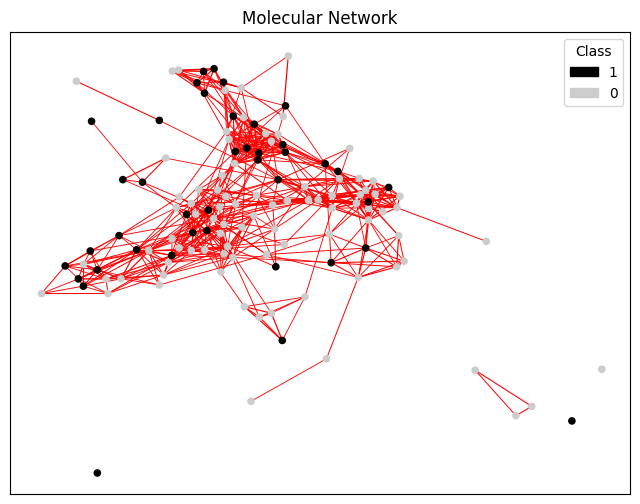

In [13]:
draw_graph_with_attributes(graph)

# Plots

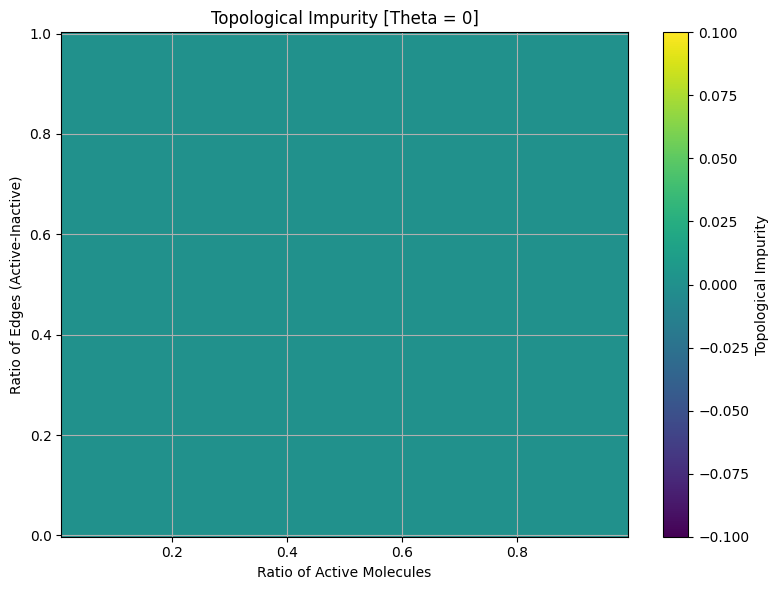

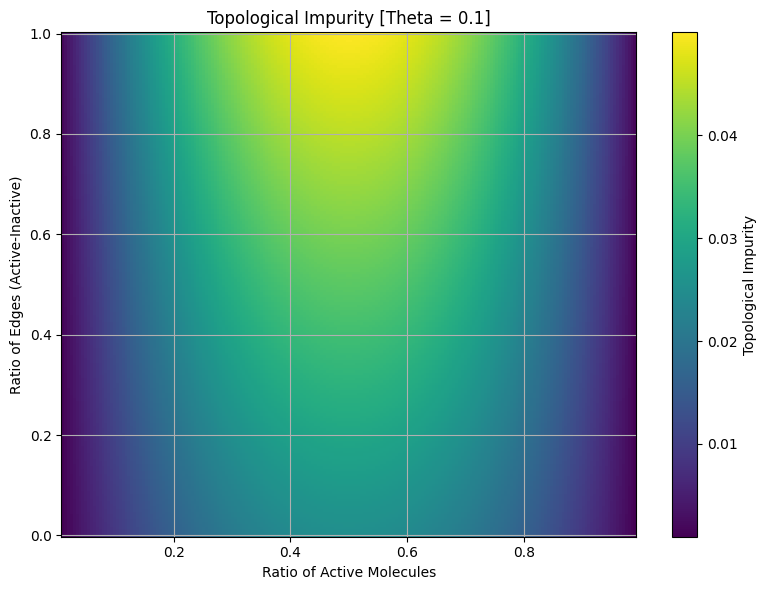

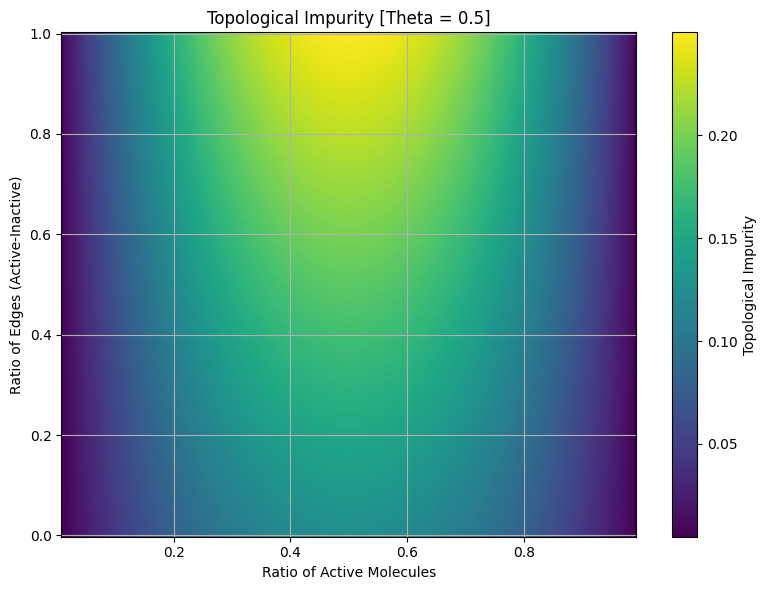

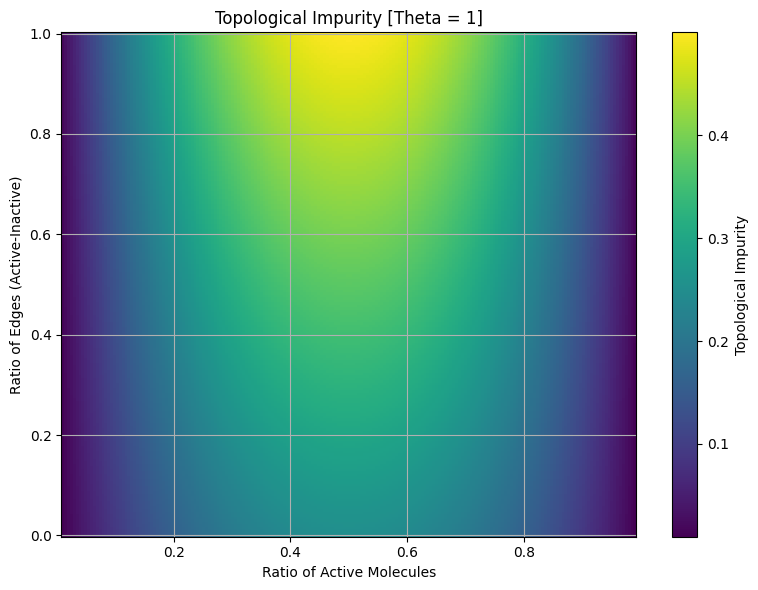

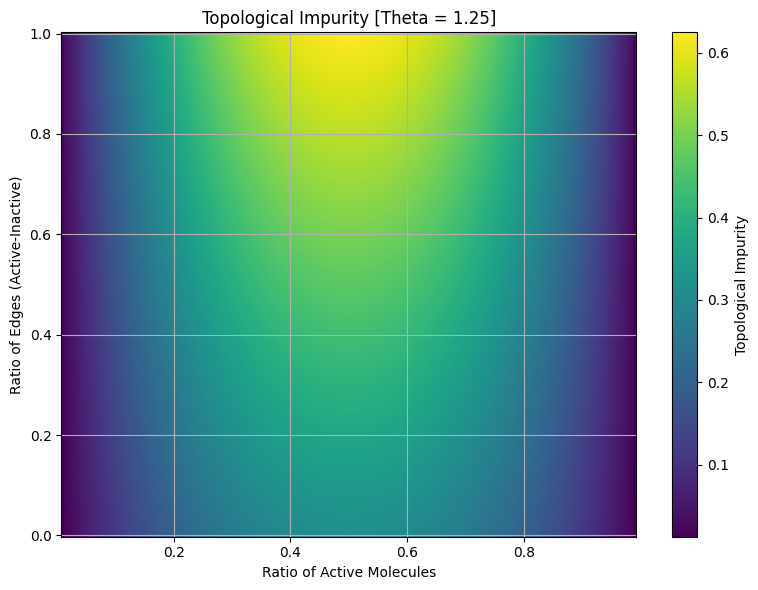

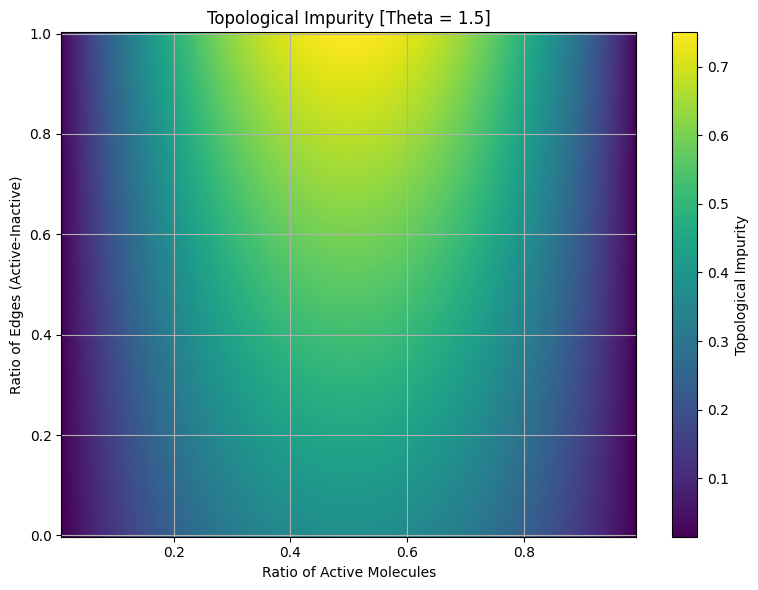

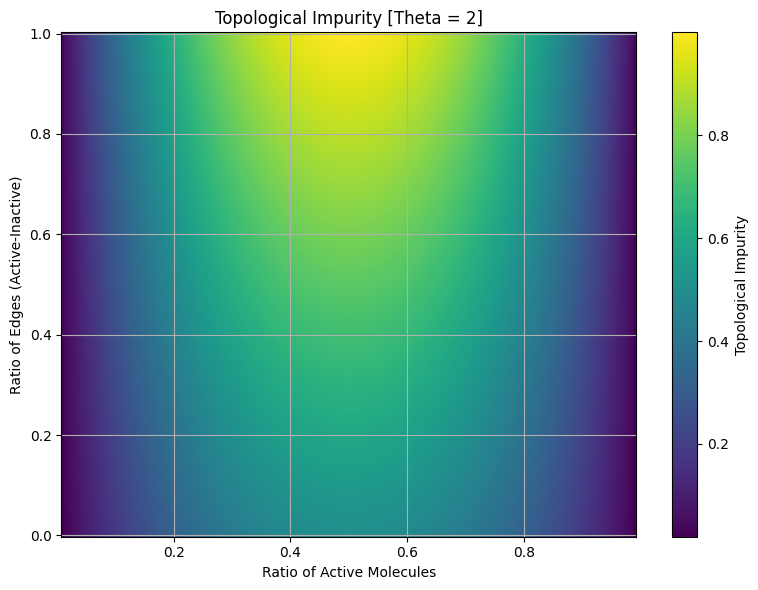

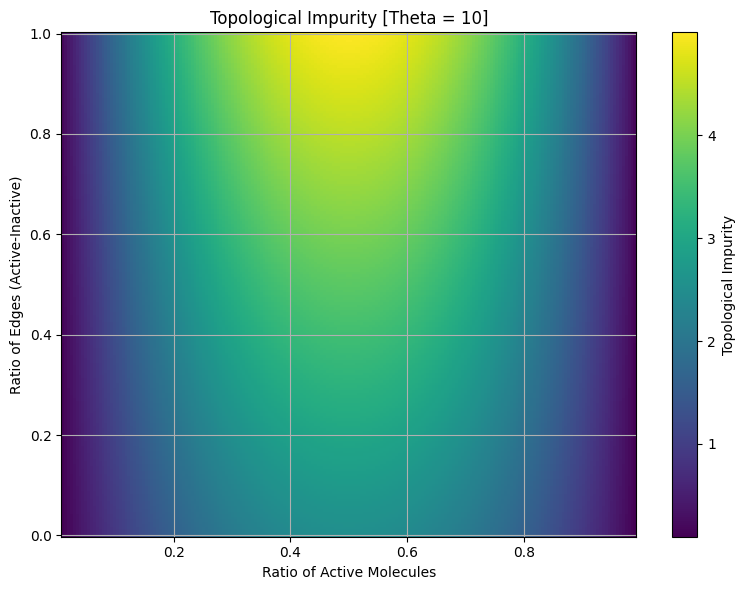

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Define a function to calculate TGI_binary
def TGI_binary(ratio_active, ratio_inactive, edge_ratio, theta):
    """
    Calculates Topological Impurity (TGI) for binary classification.

    Args:
    ratio_active: Ratio of active molecules (0 to 1).
    ratio_inactive: Ratio of inactive molecules (0 to 1).
    edge_ratio: Ratio of edges between active and inactive molecules (0 to 1).

    Returns:
    TGI value.
    """
    return ratio_active * ratio_inactive * theta * (1 + edge_ratio)

# Generate dense data for smooth visualization
num_points = 200
ratio_active = np.linspace(0.01, 0.99, num_points)
ratio_inactive = 1 - ratio_active
edge_ratios = np.linspace(0, 1, num_points)

for theta in [0, 0.1, 0.5, 1, 1.25, 1.5, 2, 10]:
    # Calculate TGI for all combinations
    TGI_values = np.zeros((num_points, num_points))
    for i, edge_ratio in enumerate(edge_ratios):
        for j, _ in enumerate(ratio_active):
            TGI_values[i, j] = TGI_binary(ratio_active[j], ratio_inactive[j], edge_ratio, theta)

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Use pcolormesh for efficient color mapping of 2D data
    extent = (ratio_active.min(), ratio_active.max(), edge_ratios.min(), edge_ratios.max())
    plt.pcolormesh(ratio_active, edge_ratios, TGI_values, cmap='viridis', norm=Normalize(vmin=TGI_values.min(), vmax=TGI_values.max()))

    # Customize the plot
    plt.xlabel('Ratio of Active Molecules')
    plt.ylabel('Ratio of Edges (Active-Inactive)')
    plt.title(f'Topological Impurity [Theta = {theta}]')
    plt.grid(True)

    # Colorbar
    plt.colorbar(label='Topological Impurity')

    # Show the plot
    plt.tight_layout()
    plt.show()


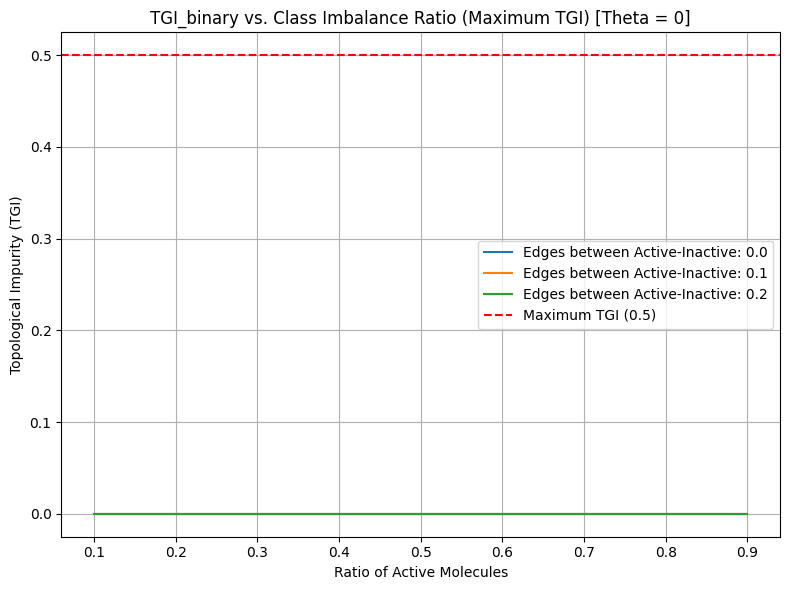

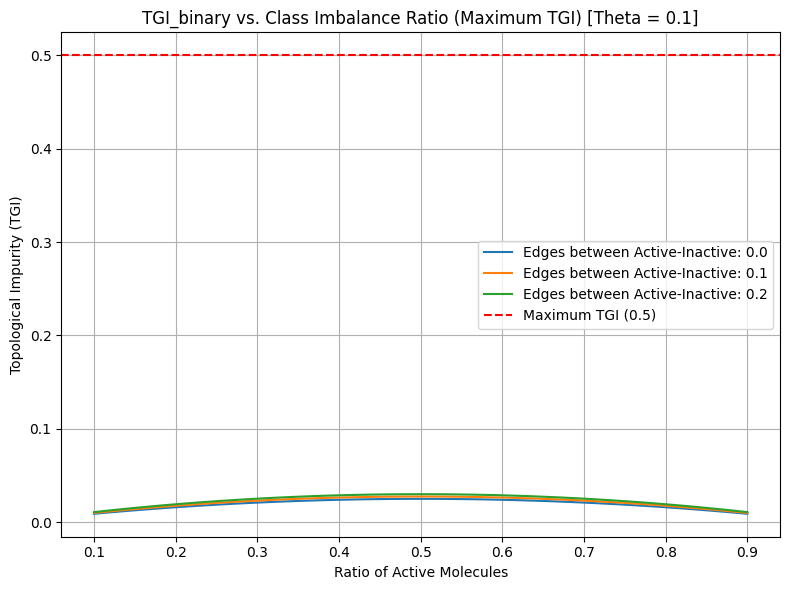

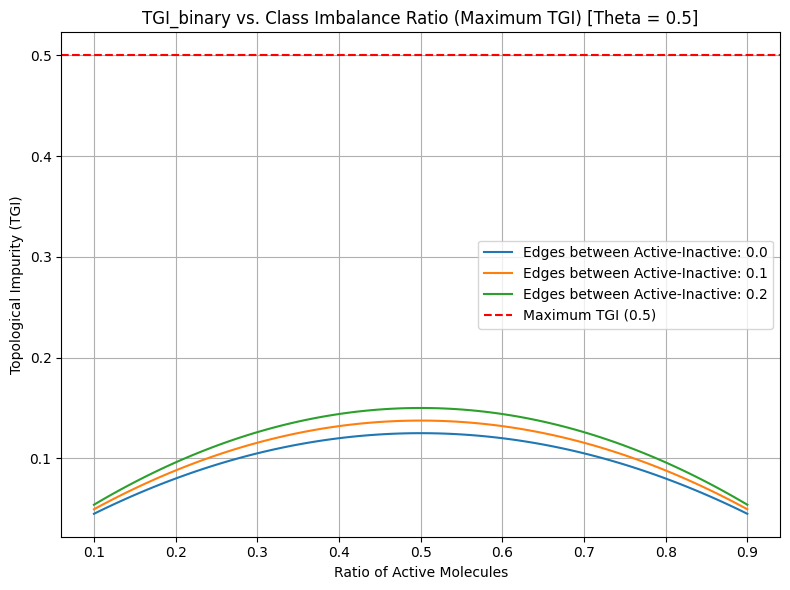

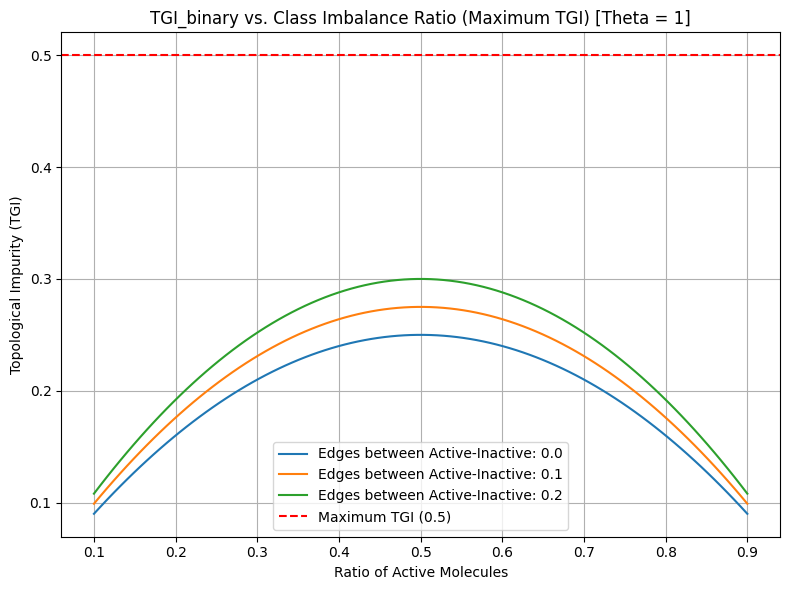

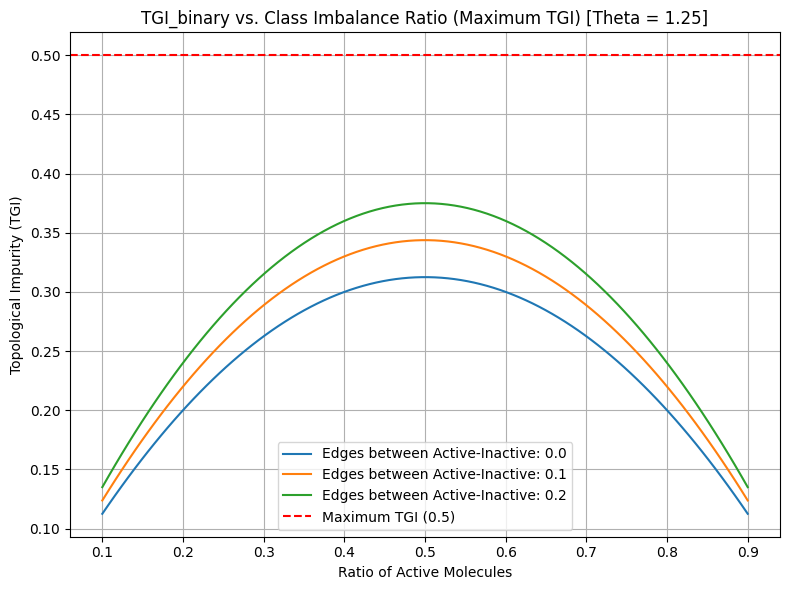

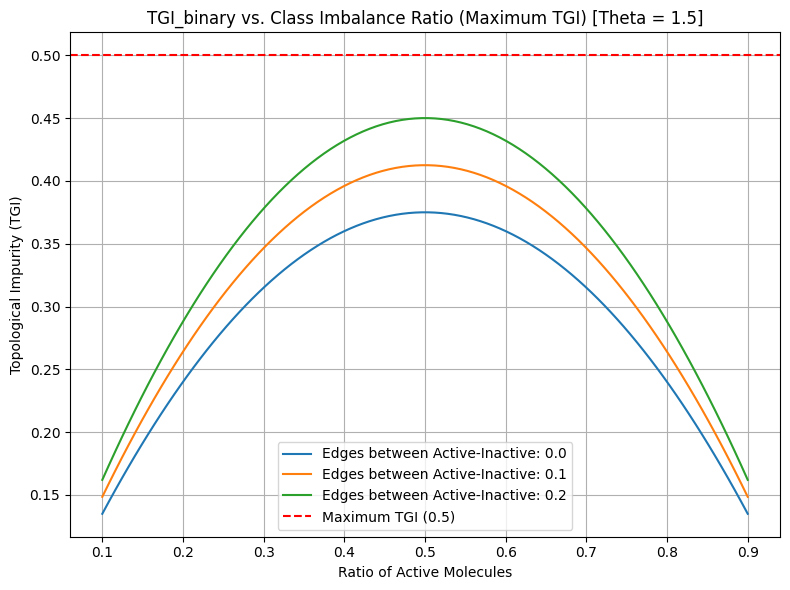

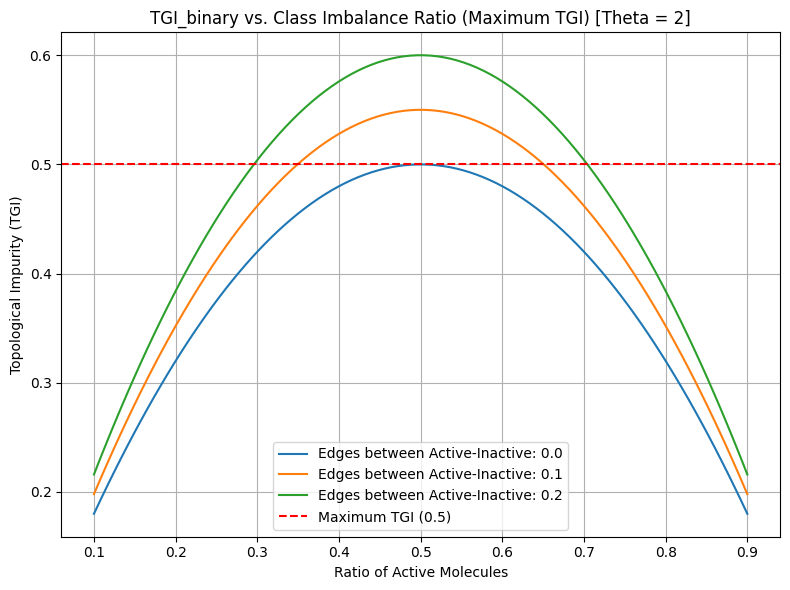

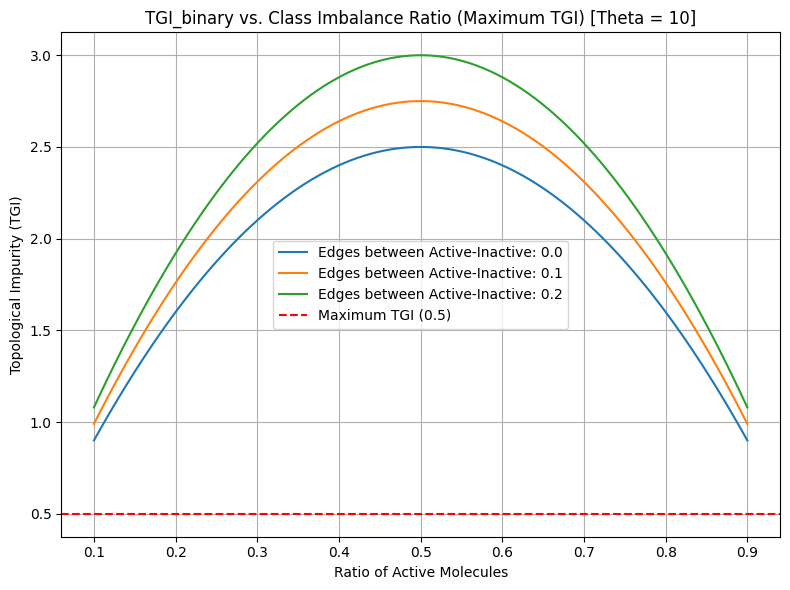

In [21]:
# Define a function to calculate TGI_binary
def TGI_binary(ratio_active, ratio_inactive, edge_ratio, theta):
    """
    Calculates Topological Impurity (TGI) for binary classification.

    Args:
      ratio_active: Ratio of active molecules (0 to 1).
      ratio_inactive: Ratio of inactive molecules (0 to 1).
      edge_ratio: Ratio of edges between active and inactive molecules (0 to 1).

    Returns:
      TGI value.
    """
    return ratio_active * ratio_inactive * theta * (1 + edge_ratio)

# Generate data for plotting TGI vs class imbalance ratio
ratio_active = np.linspace(0.1, 0.9, 100)
ratio_inactive = 1 - ratio_active
edge_ratios = [0, 0.1, 0.2]  # Different edge ratios for multiple plots
max_tgi = 0.5  # Maximum TGI value

for theta in [0, 0.1, 0.5, 1, 1.25, 1.5, 2, 10]:
  # Calculate TGI for each edge ratio
  TGI_values = []
  for edge_ratio in edge_ratios:
      TGI = TGI_binary(ratio_active, ratio_inactive, edge_ratio, theta)
      TGI_values.append(TGI)

  # Create the plot
  plt.figure(figsize=(8, 6))
  for i, edge_ratio in enumerate(edge_ratios):
      plt.plot(ratio_active, TGI_values[i], label=f'Edges between Active-Inactive: {edge_ratio:.1f}')

  # Plot the maximum TGI value as a horizontal line
  plt.axhline(y=max_tgi, color='r', linestyle='--', label='Maximum TGI (0.5)')

  # Customize the plot
  plt.xlabel('Ratio of Active Molecules')
  plt.ylabel('Topological Impurity (TGI)')
  plt.title(f'TGI_binary vs. Class Imbalance Ratio (Maximum TGI) [Theta = {theta}]')
  plt.grid(True)
  plt.legend()

  # Show the plot
  plt.tight_layout()
  plt.show()
